In [2]:
!pip install -U tensorflow
!pip install imageio

# Monet Paintings Generator Using CycleGAN

Every painter has its own style, as it is the case of Van Gogh, Michelangelo, Frida Kahlo, Monet, etc. Replicating this style can be challenging to any person with no experience in the field of painting. Identify the patterns and replicate them into an artwork it's not the easiest task for us as humans. Nevertheless, neural networks are especially effective performing this tasks, this time talking specificly about Generative Adversarial Networks (GAN). In this document we will explore the uses of GAN, generating Monet's styled photos.

<img src="https://media.nga.gov/iiif/5dd2009f-7782-43d8-9892-be5733d8f43b/full/!740,560/0/default.jpg" alt="Monet Painting" style="width:500px;">

***(NGA Gov, 2024)***

## How does a GAN works?

This type of Neural Network consist basicly in a generator and a discriminator. The generator is a neural network which its output is meant to be a styled image good enough to "fool" the discriminator and make him believe that is a "real" image. The discriminator is in charge of deciding whether and image is "real" or not.
What do we mean with real? A "real" image is in this case a real monet painting.

This two Neural Networks compete each other to generate a realistically styled photo, hence the name.

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg?hl=es-419" alt="GAN Schema" width="500"/>

***(Google for developers, 2022)***

### CycleGAN a variant of GANs

However, in this document we will focus on a variant of GANs called CycleGAN, which consists on the same principles of the GANs, a discriminator and a generator. The main difference of this variant is that once the image is styled, it is then unstyled back. This is done to ensure the preservation of the characteristics of the original image, computing and minimizing the loss of the four operations performed (Monet Discriminator, Monet Generator, Photo Discriminator, Photo Generator). This approach leads to a significant improvement of the performance of the model, as preserving the essence of the original photo its necessary to have a measurement of the similarity between these two.

# Exploratory Data Analysis - (EDA)

## Data Loading
In this project we will use TPUs to train our model, these devices can significantly improve the time of training. To make use of them it's necessary to feed our model with tfrecords, the format used to train models with TPU.

In [3]:
import os
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras.layers import LayerNormalization
from tensorflow import keras
from tensorflow.keras import layers

try:
    # Get the connected TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver("local")
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # Set strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: 
Number of replicas: 1
2.16.1


In [4]:
# Read the tfrecords files
DS_PATH = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(DS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(DS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
# Read the number of records in jpg
MONET_JPG = "/kaggle/input/gan-getting-started/monet_jpg"
PHOTO_JPG = "/kaggle/input/gan-getting-started/photo_jpg"

print(f"Monet records {len(os.listdir(MONET_JPG))}")
print(f"Photo records {len(os.listdir(PHOTO_JPG))}")

Monet records 300
Photo records 7038


In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    """ 
    Decode a tfrecotd to image 
    """
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    """ 
    Read a tfrecords and return an image 
    """
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    """ 
    Load the dataset and configures it for the TPUs 
    """
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
# Datasets of monet and real photos
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [9]:
# First example of each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

## Data Analysis

The mean intensity, and the standard deviation of the pixels are two metrics that can tell us a lot about the distribution of the data. The distribution can give us a hint of the differences between real photos and monet paintings.

In [10]:
import cv2
import numpy as np
import os

def calculate_dataset_statistics(dataset_path):
    """
    Calculate the pixel intensity std deviation and mean
    """
    total_images = 0
    pixel_intensities = []

    for filename in os.listdir(dataset_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image = cv2.imread(os.path.join(dataset_path, filename), cv2.IMREAD_GRAYSCALE)

            total_images += 1
            pixel_intensities.extend(image.flatten())

    pixel_intensities = np.array(pixel_intensities)

    mean_intensity = np.mean(pixel_intensities)
    std_dev_intensity = np.std(pixel_intensities)

    return total_images, mean_intensity, std_dev_intensity

In [11]:
# Print statistics of the photos
total_images, mean_intensity, std_dev_intensity = calculate_dataset_statistics(PHOTO_JPG)
mon_total_images, mon_mean_intensity, mon_std_dev_intensity = calculate_dataset_statistics(MONET_JPG)

print("Real Photos \n----------------------")
print(f"Image Number: {total_images}")
print(f"Mean pixel intensity: {mean_intensity}")
print(f"Pixel std deviation: {std_dev_intensity}")

print("\nMonet \n----------------------")
print(f"Image Number: {mon_total_images}")
print(f"Mean pixel intensity: {mon_mean_intensity}")
print(f"Pixel std deviation: {mon_std_dev_intensity}")

Real Photos 
----------------------
Image Number: 7038
Mean pixel intensity: 103.06997464725531
Pixel std deviation: 63.30017037624318

Monet 
----------------------
Image Number: 300
Mean pixel intensity: 132.1055167643229
Pixel std deviation: 55.393773131710894


In this case the images present a very similar distributions. This can contribute to an improvement of the training process and give a more natural and coherent look to the generated images.

### Examples

For a better understanding of the data here are some examples of the training photos:

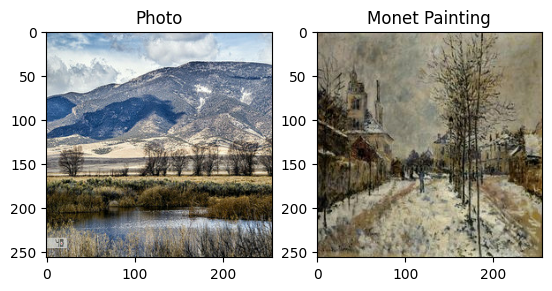

In [12]:
import matplotlib.pyplot as plt

#Print the examples of images
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet Painting')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Both of the types of photos we have have the same size (256 x 256) and three channels which are Red, Green and Blue (RGB).

# Model

## Architecture

First, we define a downsample layer consisting of:
1. 2d Convolution - Reduces the size by two because of the stride of two.
2. Instance Normalization - Only in first layer, to prevent overfitting and improve the convergence.
3. Leaky ReLU - To prevent the dying ReLU

Then, a upsample Layer consisting of:
1. 2d Transposed Convolution - Used to augment dimensionality.
2. Instance Normalization - Only in first three layers, to prevent overfitting and improve the convergence.
3. Dropout - To improve the generalization of the model.
4. ReLU - ReLU activation function.

In [13]:
OUTPUT_CHANNELS = 3
with strategy.scope():
    class InstanceNormalization(layers.Layer):
        """ 
        Normalization layer, unlike the batch normalization, the normalization done
        by this layer is done on every image and not the entire batch        
        """
        def __init__(self, gamma_initializer='random_normal', epsilon=1e-5):
            super(InstanceNormalization, self).__init__()
            self.epsilon = epsilon
            self.gamma_initializer = gamma_initializer

        def build(self, input_shape):
            self.scale = self.add_weight(
                name='scale',
                shape=input_shape[-1:],
                initializer=self.gamma_initializer,
                trainable=True
            )
            self.offset = self.add_weight(
                name='offset',
                shape=input_shape[-1:],
                initializer='zeros',
                trainable=True
            )

        def call(self, inputs):
            mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
            inv = tf.math.rsqrt(variance + self.epsilon)
            normalized = (inputs - mean) * inv
            return self.scale * normalized + self.offset

    def downsample(filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

        if apply_instancenorm:
            result.add(InstanceNormalization(gamma_initializer=gamma_init))

        result.add(layers.LeakyReLU())

        return result

    def upsample(filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))

        result.add(InstanceNormalization(gamma_initializer=gamma_init))

        if apply_dropout:
            result.add(layers.Dropout(0.5))

        result.add(layers.ReLU())

        return result

### Generator
The generator doesn´t have only sequential connections, instead it has skip connections between the down_stack and the up_stack. This prevents the vanishing gradient and helps the model to recover specific details from the original image.

It consists of:
1. Input Layer - The input should have the shape 256x256x3, the size of the images previously defined.
2. Down Stack - Eight downsample layers with skip connections to the Up Stack.
3. Up Stack - Seven upsample layers
4. 2d Transposed Convolution - Used to augment dimensionality and get a 256x256x3 result.

In [14]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

The discriminator consists of:
1. Input Layer - The input should have the shape 256x256x3, the size of the images previously defined.
2. Down Stach - The down stack consists of 3 downsample layers.
3. Zero Padding - The zero padding layer fill with zeros the borders of the image to avoid loosing information on the convolution layer.
4. 2d Convolution - Reduces the size and catch complex patterns.
5. Instance Normalization - Only in first three layers, to prevent overfitting and improve the convergence.
6. Leaky Relu - To prevent the dying ReLU.
7. Zero Padding - The zero padding layer fill with zeros the borders of the image to avoid loosing information on the convolution layer.
8. 2d Convolution - Generates the activation map to be compared with the generated by real Monet paintings.

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = InstanceNormalization(gamma_initializer=gamma_init)(conv)
    

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [27]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

The image below correspond to a non-trained generator. The image is just random noise caused by the random initialization of the kernels around zero.

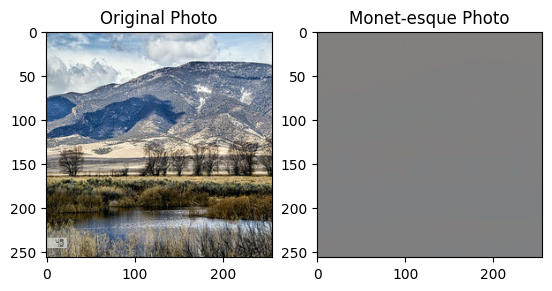

In [28]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### CycleGAN

The CycleGAN combines the previously defined architectures and apply loss functions to adjust the gradients

In [29]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Cycle photo to monet and back
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Cycle monet to photo and back
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Self generation
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator for real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator for fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator loss functions
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle loss function
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total loss combining past two
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        
        #Apply gradients to the generators and discriminators
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
    
    def call(self, real_photo):
        # Generate Monet styled photo
        fake_monet = self.m_gen(real_photo, training=False)
        return fake_monet

### Loss Functions

#### Discriminator Loss

The discriminator loss function consists on:
1. Calculate the real loss using binary crossentropy comparing the data with a ones vector.
2. Calculte the generated loss using binary crossentropy comparing the data with a zeros vector.
3. Get the total loss.
4. Multiply by .5 to normalize the contribution of each loss.

In [30]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

#### Generator Loss

The generator loss consist on:
1. Calculte the generated loss using binary crossentropy comparing the data with a ones vector. 

In [31]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

#### Cycle Loss

The Cycle Loss consist of:
1. Calculate the difference between the real image and the cycled image.
2. Calculate the mean of the difference.
3. Multiply by lambda.

In [32]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

#### Identity Loss

The Identity Loss function takes as parameters a real image (It can be styled or unstyled) and a self-generated image (Doesn´t change style, it´s generated with the same generator).
1. Calculate the absolute difference between real image and same image.
2. Calculate the mean of the difference.
3. Multiply by lambda an by .5.

In [33]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Optimizers

The optimizer used in this model is Adam with a beta of .5 and an initial learning rate of 2e-4.

In [34]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Model declaration and compilation

In [35]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )


### Model Training

#### Personalized Callback

The Callback declared below has two main functions:
1. Save images on each epoch of training.
2. Save the progress of the weights every five epochs.

In [36]:
from tensorflow.keras import callbacks
def tensor_to_image(tensor):
    return tf.keras.preprocessing.image.array_to_img(tensor[0])

class SaveOutputImages(callbacks.Callback):
    def __init__(self, generator_model, input_data):
        super(SaveOutputImages, self).__init__()
        self.generator_model = generator_model
        self.input_data = input_data
        self.epoch_images = [example_photo]

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generator_model.predict(self.input_data)

        epoch_image = tensor_to_image(generated_images)
        self.epoch_images.append(epoch_image)
        if epoch % 5 == 0:
            self.generator_model.m_gen.save_weights(f"model_{epoch}.weights.h5")

with strategy.scope():
    output_saver = SaveOutputImages(generator_model=cycle_gan_model, input_data=example_photo)
    #cycle_gan_model.load_weights("/kaggle/input/epoch14gam/model_14.weights.h5")

#### Training Process
The model is trained in 25 epochs using the output_saver callback.

In [37]:
with strategy.scope():
    history = cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=25,
        callbacks=[output_saver]
    )

Epoch 1/25


I0000 00:00:1710212661.843298     170 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_19', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steponet_gen_loss: 5.2480 - photo_disc_loss: 0.6527 - photo_gen_loss: 5.268
300/300 ━━━━━━━━━━━━━━━━━━━━ 171s 214ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 5.2480 - photo_disc_loss: 0.6527 - photo_gen_loss: 5.2686 - loss: 0.0000e+00
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - monet_disc_loss: 0.5735 - monet_gen_loss: 3.7749 - photo_disc_loss: 0.6482 - photo_gen_loss: 3.629
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - monet_disc_loss: 0.5735 - monet_gen_loss: 3.7749 - photo_disc_loss: 0.6482 - photo_gen_loss: 3.6299 - loss: 0.0000e+00
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.6649 - photo_disc_loss: 0.6422 - photo_gen_loss: 3.538
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.6649 - photo_disc_loss: 0.6422 - photo_gen_loss: 3.5381 - loss: 0.0000e+00
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step/step - monet_disc_loss: 0.6213 - monet

# Results

The train of the model is visible on the images below, which contains the progress of the generated images every five epochs and the original image.

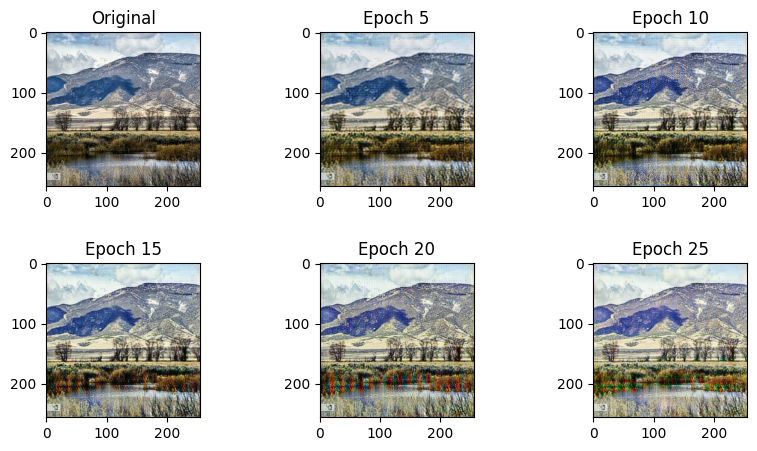

In [39]:
axis = 231
plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=.5, wspace = .2)
plt.subplot(axis)
plt.title('Original')
plt.imshow(output_saver.epoch_images[0][0]*.5 + .5)

for i in range(5, 26, 5):
    try:
        plt.subplot(axis + int(i/5))
        plt.title(f"Epoch {i}")
        plt.imshow(output_saver.epoch_images[i])
    except:
        print(f"No epoch {i}")

#### Model Evolution

The gif above shows the evolution of the generator. And how the model learns to transfer an image from one domain to another. We can observe a significant improvement of the model performance on each epoch. Aditionally, we can observe a notorious change of the color and texture of the photo, looking more like the monet style.

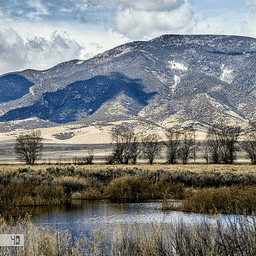

In [46]:
import imageio
import numpy as np

gif_path = '/kaggle/working/animated.gif'
images_gif = [np.uint8(output_saver.epoch_images[0][0]*125.5+125.5)] + [np.uint8(image) for image in output_saver.epoch_images[1:]]
imageio.mimsave(gif_path, images_gif, duration=2000)

from IPython.display import Image, display
display(Image(filename=gif_path))

#### Submission File Creation

Create a zip with the generated images.

In [44]:
! mkdir ../images

mkdir: cannot create directory '../images': File exists


In [45]:
import numpy as np
import PIL
import shutil

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusions

The objective of this document was satisfactorily fulfilled, obtaining a generator of monet style images from scratch. Applying machine learning models and concepts like Generative Adversarial Networks. This is a field with a great importance nowadays, the generative AI is in constant growth.

One possible improvement for future projects is expand the dataset by using images of higher quality and sectioning the images in 256x256 chunks. Applyin this generator we could generate higher quality images using the same generator, applying it all over the image divided in chuncks, concatenating it just after.

This projects improves my hability to construct neural networks solutions from scratch for different purposes. This Neural Network will be deployed to a web app using cloud computing as the final stage of this project.

**Bibliography**

Claude Monet. (2024). Retrieved March 10, 2024, from Nga.gov website: https://www.nga.gov/features/slideshows/claude-monet.html#slide_2

El generador. (2022). Retrieved March 10, 2024, from Google for Developers website: https://developers.google.com/machine-learning/gan/generator?hl=es-419

amyjang. (2020, August 29). Monet CycleGAN Tutorial. Retrieved March 10, 2024, from Kaggle.com website: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial